In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
url = "https://raw.githubusercontent.com/tech-lab-BI/test/main/spam_ham_dataset.csv"
data = pd.read_csv(url)
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [28]:
data.shape

(5171, 4)

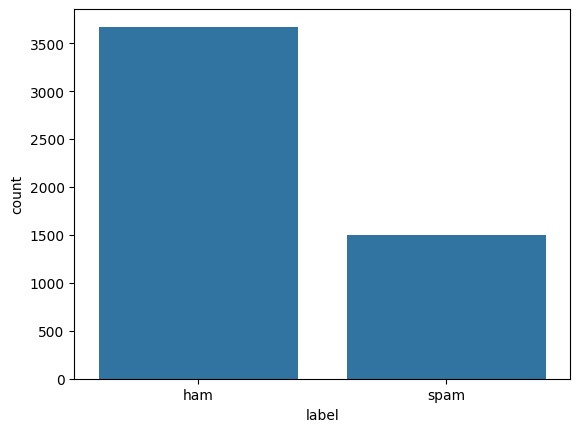

In [29]:
sns.countplot(x='label', data=data)
plt.show()

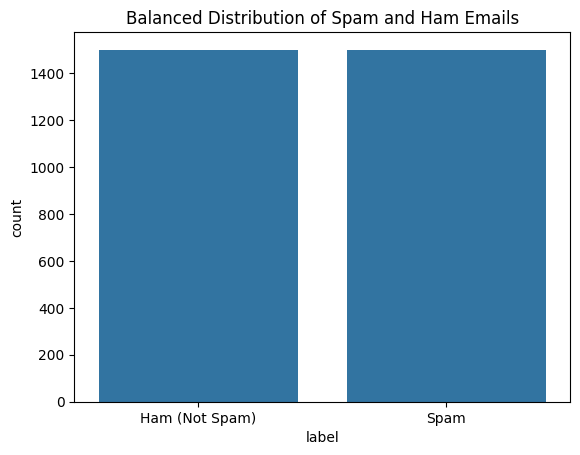

In [30]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample Ham emails to match the number of Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=1)

# Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# Visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

In [31]:
# balanced_data.head()
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,1116,ham,": revised 7 / 00 assignment , termination , ex...",0
1,2583,ham,: feb 12 th sale to aquila\r\nfyi\r\ndaren - -...,0
2,267,ham,: hpl / eastrans nom - 2 / 8 / 00 ; hpl busby ...,0
3,3103,ham,: oasis transport imbalances\r\ncurrent mth : ...,0
4,1652,ham,": hpl nom for sept . 22 , 2000\r\n( see attach...",0


In [32]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,1116,ham,revised 7 00 assignment termination expira...,0
1,2583,ham,feb 12 th sale to aquila\r\nfyi\r\ndaren o...,0
2,267,ham,hpl eastrans nom 2 8 00 hpl busby redeli...,0
3,3103,ham,oasis transport imbalances\r\ncurrent mth 20...,0
4,1652,ham,hpl nom for sept 22 2000\r\n see attached f...,0


In [33]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')#meaningless words

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,1116,ham,revised 7 00 assignment termination expiration...,0
1,2583,ham,feb 12 th sale aquila fyi daren 12 th sale aqu...,0
2,267,ham,hpl eastrans nom 2 8 00 hpl busby redelivery s...,0
3,3103,ham,oasis transport imbalances current mth 201 k 7...,0
4,1652,ham,hpl nom sept 22 2000 see attached file hplo 92...,0


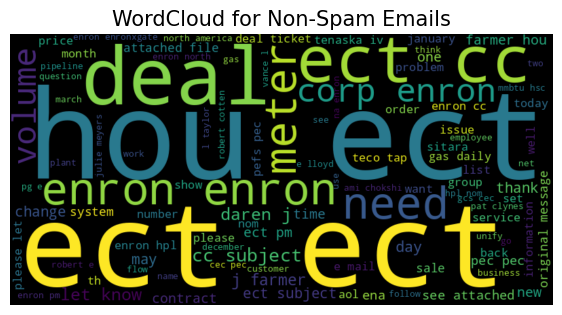

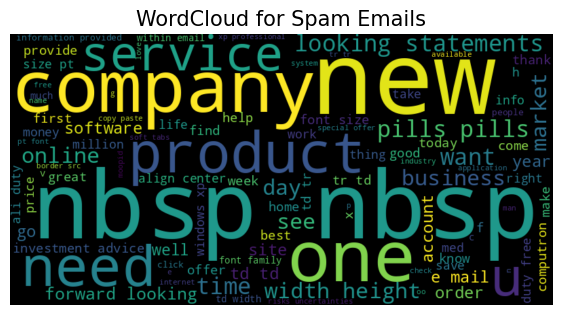

In [34]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

In [35]:
#not understand
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

In [36]:
#not understand
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.5156 - loss: 0.6924 - val_accuracy: 0.6233 - val_loss: 0.6731 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7645 - loss: 0.5605 - val_accuracy: 0.9367 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9460 - loss: 0.2115 - val_accuracy: 0.9350 - val_loss: 0.2388 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9610 - loss: 0.1574 - val_accuracy: 0.9417 - val_loss: 0.2175 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9636 - loss: 0.1493 - val_accuracy: 0.9417 - val_loss: 0.2206 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9621 - loss: 0.1470 - val_accuracy: 0.9350 - val_loss: 0.2434 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9651 - loss: 0.1380 - val_acc

In [40]:
model

<Sequential name=sequential, built=True>

In [43]:
# Your custom message
message = input("Enter messaage : ")

# Convert text → sequence of integers
seq = tokenizer.texts_to_sequences(message)

# Pad to same length used in training (replace 100 with your actual maxlen)
pad = pad_sequences(seq, maxlen=100)

# Predict
prediction = model.predict(pad)

print(prediction)  # See raw output
print("🚫 Spam" if prediction[0][0] > 0.5 else "✅ Not Spam")


Enter messaage : Hi Bikram,  Didn’t apply yet? Here’s your extra shot!  The deadline for HP Power Lab 2.0 by Hindustan Petroleum has been extended giving you another chance to apply!  Don’t miss out on this opportunity to secure a summer internship with Hindustan Petroleum and win exciting rewards.
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[0.06149074]
 [0.05918269]
 [0.05918269]
 [0.06794047]
 [0.05918269]
 [0.06479521]
 [0.06621017]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.06706331]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.06518753]
 [0.06518753]
 [0.06146333]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.06254993]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.06149073]
 [0.06254993]
 [0.06621017]
 [0.06254993]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.05918269]
 [0.06394978]
 [0.06621017]
 [0.05918269]
 [0.06254993]
 [0.06399199]
 [0.05918269]
 [0.06621017]
 [0.05918269]
 [0.